In [1]:
import os
import argparse
import numpy as np
import os.path as osp
from copy import deepcopy
from easydict import EasyDict as edict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from src.cf_methods import c3lt 
from src.datasets import DatasetBuilder

from src.models.classifiers import SimpleCNNtorch
from src.evaluation.local_instability import perturb_sample
from src.utils import extract_factual_instances, filter_valid_factuals
from src.utils import seed_everything, get_config, load_model_weights
from src.utils import evaluate_classification_model, plot_boxplot

2025-05-13 07:35:47.522975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747114547.541326 3795206 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747114547.546709 3795206 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747114547.561057 3795206 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747114547.561076 3795206 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747114547.561078 3795206 computation_placer.cc:177] computation placer alr

In [2]:
seed_everything()

In [3]:
import sys
sys.argv = ['']

In [15]:
config_path = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/configs/revise_fmnist_binary.yaml'
config = get_config(config_path)
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

In [16]:
# Create an args object to pass all relevant parameters 
weights_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/src/cf_methods/c3lt/weights'
# '/data/leuven/365/vsc36567/Counterfactual-Robustness-Benchmark/src/recourse_methods/c3lt/weights'
clf_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/fmnist_classification/binary/checkpoints'
# '/data/leuven/365/vsc36567/Counterfactual-Robustness-Benchmark/src/models/weights'
log_path ='/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/c3lt_binary'

args = c3lt.args.init_parser()
args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.log_path = log_path
args.gen_path = osp.join(weights_dir, 'generator_fmnist.pth')
args.disc_path = osp.join(weights_dir, 'discriminator_fmnist.pth')
args.enc_path = osp.join(weights_dir, 'encoder_fmnist.pth')
args.cls_path = osp.join(clf_dir, 'fmnist_0_4_epoch=06_val_accuracy=0.99.pth')
args.dataset_path = '/data/leuven/365/vsc36567/Cf-Robustness-Benchmark/data'
args.cls_1 = 0  # 0
args.cls_2 = 1  # 4
args.num_classes = 2
args.classifier_args={**config.classifier.args, 
                    'num_classes': config.data.num_classes,
                    'img_size': config.data.img_size
}
args.ndf=32
# args.cls_type = 'bce'
args.extracted_layers = ['main']
args.output = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/c3lt_binary/results'

In [17]:
def dataloader_pair(args, dataset, is_train):
    """
        returns dataloaders for a class pair.

    :param args:
    :param is_train:
    :return:
    """
    dataset_1 = deepcopy(dataset)
    dataset_2 = deepcopy(dataset)

    # extract samples only of class 1
    idx_1 = dataset_1.data.targets == args.cls_1
    dataset_1.data.data = dataset_1.data.data[idx_1]
    dataset_1.data.targets = dataset_1.data.targets[idx_1]

    # extract samples only of class 2
    idx_2 = dataset_2.data.targets == args.cls_2
    dataset_2.data.data = dataset_2.data.data[idx_2]
    dataset_2.data.targets = dataset_2.data.targets[idx_2]

    dataloader_1 = DataLoader(dataset_1, batch_size=args.batch_size,
                              shuffle=is_train, pin_memory=True, drop_last=False)
    dataloader_2 = DataLoader(dataset_2, batch_size=args.batch_size,
                              shuffle=is_train, pin_memory=True, drop_last=False)

    return  dataloader_1, dataloader_2

In [18]:
dataloaders = dataloader_pair(args, ds_builder.train_dataset, is_train=True)
dataloaders_test = dataloader_pair(args, ds_builder.test_dataset, is_train=False)

# Training

In [12]:
c3lt.train.train_c3lt(args, [dataloaders, dataloaders_test])

Generator loaded!
Discriminator loaded!
Encoder loaded!
Classifier loaded!

Training Starts...

[Epoch 0/200] [TRAIN Loss: 0.28786]

EVAL [CLS loss: 0.0138]  [PROX loss: 0.0712]  [CYC Loss: 0.2235]  [ADV loss: 0.6671]  [EVAL loss: 0.0439] 
EVAL [COUT: 0.7846]  [Validity: 99.60 %]  [Proximity: 0.3136]

[Epoch 1/200] [TRAIN Loss: 0.03772]
[Epoch 2/200] [TRAIN Loss: 0.03440]
[Epoch 3/200] [TRAIN Loss: 0.03199]
[Epoch 4/200] [TRAIN Loss: 0.03014]
[Epoch 5/200] [TRAIN Loss: 0.02855]
[Epoch 6/200] [TRAIN Loss: 0.02719]
[Epoch 7/200] [TRAIN Loss: 0.02620]
[Epoch 8/200] [TRAIN Loss: 0.02537]
[Epoch 9/200] [TRAIN Loss: 0.02469]
[Epoch 10/200] [TRAIN Loss: 0.02411]

EVAL [CLS loss: 0.0053]  [PROX loss: 0.0676]  [CYC Loss: 0.1402]  [ADV loss: 0.6528]  [EVAL loss: 0.0267] 
EVAL [COUT: 0.8013]  [Validity: 99.70 %]  [Proximity: 0.2955]

[Epoch 11/200] [TRAIN Loss: 0.02361]
[Epoch 12/200] [TRAIN Loss: 0.02311]
[Epoch 13/200] [TRAIN Loss: 0.02269]
[Epoch 14/200] [TRAIN Loss: 0.02233]
[Epoch 15/200] [T

KeyboardInterrupt: 

# Inference

In [19]:
import pickle
from src.evaluation.local_instability import perturb_sample

In [23]:
g = c3lt.modules.NLMappingConv(args.latent_dim).to(args.device)
mapper_weights_path = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/c3lt_binary/results_0_4/snaps/map_0_to_1_150.pt'
# load_model_weights(g, framework='torch', weights_path=mapper_weights_path)
checkpoint = torch.load(
                    mapper_weights_path, weights_only=False,
                    map_location=torch.device(args.device)
                )
            
g.load_state_dict(checkpoint)

<All keys matched successfully>

In [24]:
gen, discr = c3lt.helper.load_pretrained_gan(args)

Generator loaded!
Discriminator loaded!


In [25]:
baseline_classifier = c3lt.helper.load_pretrained_classifier(args)

Classifier loaded!


In [26]:
encoder = c3lt.helper.load_pretrained_encoder(args)

Encoder loaded!


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
cfes = []
factuals_list = []
labels_list = []

factual_class = 0
for images, labels in test_loader:
    indices = np.where(labels == factual_class)[0]
    factuals_list.append(images[indices])
    labels_list.append(labels[indices])

In [32]:
factuals = torch.concat(factuals_list)
labels = torch.concat(labels_list)
factuals.shape, labels.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

In [33]:
predictions = torch.argmax(baseline_classifier(factuals.to(device)), axis=1).detach().cpu()
valid_indices = np.where(predictions == labels)[0]
factuals = factuals[valid_indices] 
labels = labels[valid_indices]
factuals.shape, labels.shape

(torch.Size([990, 1, 28, 28]), torch.Size([990]))

## Local Instability

In [34]:
noise_levels = [0.001, 0.0025, 0.005, 0.0075, 0.01]

In [35]:
from functools import reduce


save_dir = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/c3lt_binary'

n = 100
factuals_pert = {}    
indices_pert = {}

for noise_level in noise_levels:
    factuals_pert[noise_level] = perturb_sample(factuals, n_samples=1, noise_magnitude=noise_level)
    pert_sample = torch.Tensor(factuals_pert[noise_level])

    # Check whether perturbed instances lead to the same class prediction
    predictions = torch.argmax(baseline_classifier(pert_sample.to(device)), axis=1).detach().cpu()
    indices = np.where(predictions == labels)[0]
    print(f'Number of valid perturbed factuals for the added noise level {noise_level}: ', indices.shape[0])
    pert_sample = pert_sample[indices] 
    indices_pert[noise_level] = indices

Number of valid perturbed factuals for the added noise level 0.001:  989
Number of valid perturbed factuals for the added noise level 0.0025:  990
Number of valid perturbed factuals for the added noise level 0.005:  988
Number of valid perturbed factuals for the added noise level 0.0075:  989
Number of valid perturbed factuals for the added noise level 0.01:  988


In [36]:
final_indices = reduce(np.intersect1d, (valid_indices, *list(indices_pert.values())))[:n]
factuals = factuals[final_indices] 
factuals_pert = {k : v[final_indices] for k, v in factuals_pert.items()}

with open(osp.join(save_dir, 'factuals.pkl'), 'wb') as f:
    pickle.dump(factuals, f)

for noise_level in noise_levels:
    with open(osp.join(save_dir, f'factuals_perturbed_noise_{noise_level}.pkl'), 'wb') as f:
        pickle.dump(factuals_pert[noise_level], f)

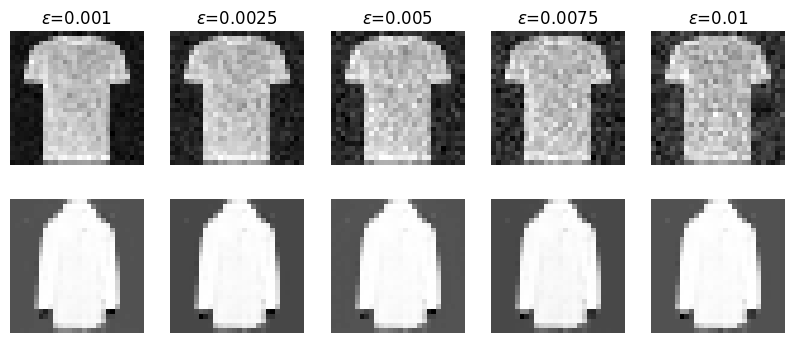

In [38]:
ind = 11

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        noise = noise_levels[j]
        if i == 0: 
            pert_image = factuals_pert[noise][ind].squeeze().squeeze() #perturb_sample(factuals_tensor[ind].unsqueeze(0), noise_magnitude=noise).squeeze().squeeze()
            axs[i, j].imshow(pert_image, cmap='gray')
            axs[i, j].set_title('$\\epsilon$='+str(noise)) 
            axs[i, j].axis('off')
        else:
            pert_sample = torch.Tensor(factuals_pert[noise]).to(device)
            latent_code_pert = encoder(pert_sample)
            mapping_pert = g(latent_code_pert)
            cfes_pert_sample = gen(mapping_pert)
            axs[i, j].imshow(cfes_pert_sample[ind].detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')
            axs[i, j].axis('off')

In [16]:
# with open('/data/leuven/365/vsc36567/Counterfactual-Robustness-Benchmark/counterfactuals/c3lt_multi/factuals.pkl', 'rb') as f:
#     factuals = pickle.load(f)
#     print(f'{factuals.shape[0]} factual instances were loaded.')

100 factual instances were loaded.


In [22]:
# factuals_pert = {}
# save_dir = '/data/leuven/365/vsc36567/Counterfactual-Robustness-Benchmark/counterfactuals/c3lt_multi'

# for noise_level in noise_levels:
#     with open(osp.join(save_dir, f'factuals_perturbed_noise_{noise_level}.pkl'), 'rb') as f:
#         factuals_pert[noise_level] = pickle.load(f)

Generate counterfcatual explanations

In [39]:
factuals = factuals.to(device)
latent_code = encoder(factuals)
map_to_target_class = g(latent_code)
cfes = gen(map_to_target_class)

In [40]:
validity = np.where(torch.argmax(baseline_classifier(cfes), axis=1).detach().cpu() == 1)[0]
validity = validity.shape[0] / cfes.shape[0]
print('Validity of the generated explanations:', validity)

Validity of the generated explanations: 1.0


In [41]:
cfes_pert = {}

for noise_level in noise_levels:
    pert_sample = torch.Tensor(factuals_pert[noise_level]).to(device)
    latent_code_pert = encoder(pert_sample)
    mapping_pert = g(latent_code_pert)
    cfes_pert[noise_level] = gen(mapping_pert) 

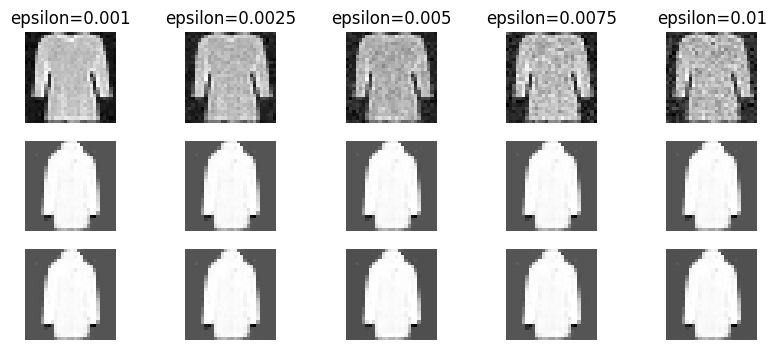

In [42]:
import matplotlib.pyplot as plt

n_rows = 3
n_cols = 5

ind = 15

# factuals_pert = {}    

# for noise_level in noise_levels:
#     factuals_pert[noise_level] = perturb_sample(factuals_tensor, n_samples=1, noise_magnitude=noise_level)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))
for i in range(n_rows):
    for j in range(n_cols):
        noise = noise_levels[j]
        if i == 0: 
            pert_image = factuals_pert[noise][ind].squeeze().squeeze() #perturb_sample(factuals_tensor[ind].unsqueeze(0), noise_magnitude=noise).squeeze().squeeze()
            axs[i, j].imshow(pert_image, cmap='gray')
            axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
        elif i == 1:
            axs[i, j].imshow(cfes[ind].squeeze().detach().cpu(), cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /wo noise')
        else:
            axs[i, j].imshow(cfes_pert[noise][ind].detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')
            # axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /w noise')
plt.show()

In [43]:
target_class = 1

validity_dict = {}
for noise_level in noise_levels:
    predictions = torch.argmax(baseline_classifier(torch.Tensor(cfes_pert[noise_level])), axis=1).detach().cpu()
    indices = np.where(predictions == target_class)[0]
    validity = indices.shape[0] / predictions.shape[0]
    validity_dict[noise_level] = validity
    print(f'Validity for the added noise level {noise_level}: ',  validity)

with open(osp.join(save_dir, 
        f'c3lt_fmnist_0_4_validity.pkl'), 'wb') as f:
        pickle.dump(validity_dict, f)

Validity for the added noise level 0.001:  1.0
Validity for the added noise level 0.0025:  1.0
Validity for the added noise level 0.005:  1.0
Validity for the added noise level 0.0075:  1.0
Validity for the added noise level 0.01:  1.0


In [44]:
from src.evaluation.local_instability import calculate_sparsity, calculate_ssim
from src.utils.visualization import plot_boxplot

In [45]:
instability_l1_list = []
ssim_list = []

for noise_level, cfe_pert_list in cfes_pert.items():
    # print('noise level:', noise_level)
    l1_temp = []
    ssim_temp = []
    for i in range(len(cfes)):
        cf = cfes[i].detach().cpu()
        cf_pert = cfe_pert_list[i].detach().cpu()

        if len(cf) == 0:
            continue
        if len(cf_pert) == 0:
            continue

        cf_tensor = torch.Tensor(cf)
        cf = cf_tensor.permute(1, 2, 0).flatten()

        cf_pert_tensor = torch.Tensor(cf_pert)
        cf_perturbed = cf_pert_tensor.permute(1, 2, 0).flatten()        

        l1_distance = sum(abs(cf - cf_perturbed)) # np.linalg.norm(cf.flatten() - cf_perturbed.flatten(), ord=1)
        l1_temp.append(l1_distance)

        ssim = calculate_ssim(cf_tensor.unsqueeze(0), cf_pert_tensor.unsqueeze(0)).item()
        ssim_temp.append(ssim)

    instability_l1_list.append(l1_temp)
    ssim_list.append(ssim_temp)
        

# output_dir = r'/data/leuven/365/vsc36567/Counterfactual-Robustness-Benchmark/output/c3lt_binary'

with open(osp.join(save_dir, f'c3lt_0_4_li_l1.pkl'), 'wb') as f:
    pickle.dump(instability_l1_list, f)

with open(osp.join(save_dir, f'c3lt_0_4_ssim.pkl'), 'wb') as f:
    pickle.dump(ssim_list, f)

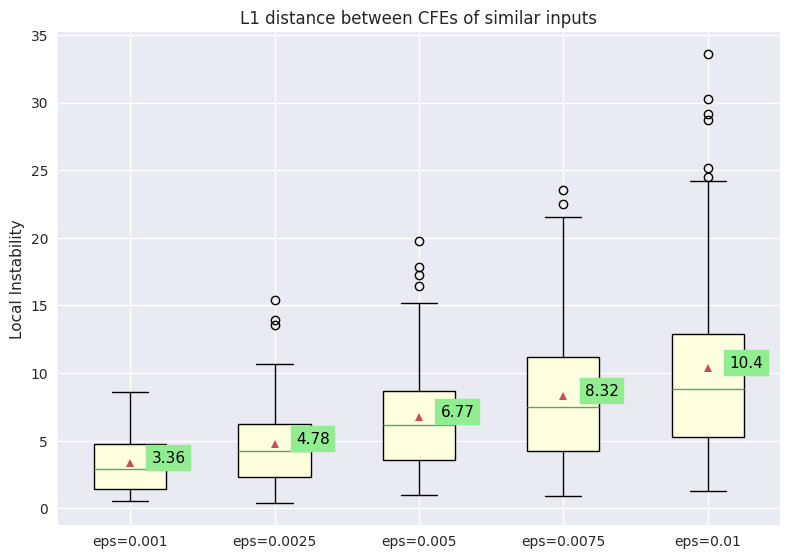

In [46]:
plt.style.use("seaborn-v0_8")


plot_boxplot(data=instability_l1_list, mean_values=np.round(np.mean(instability_l1_list, axis=1), 2),
             tick_labels=[f'eps={noise_level}' for noise_level in noise_levels],
             y_label='Local Instability', colors=['lightyellow'], title='L1 distance between CFEs of similar inputs')

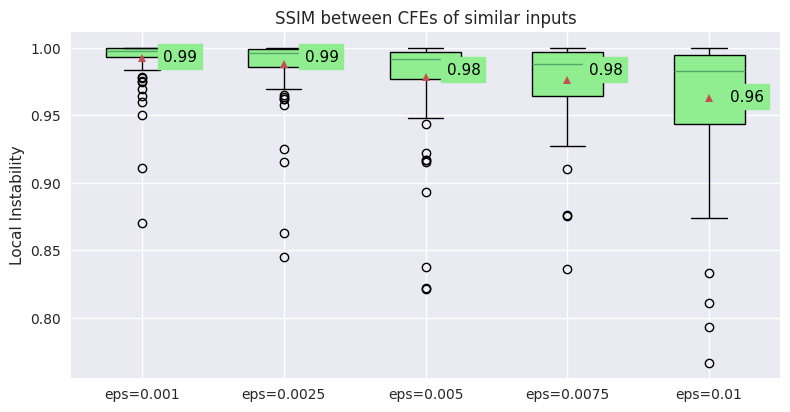

In [47]:
plt.rcParams['figure.figsize'] = [8, 4]

plot_boxplot(data=ssim_list, mean_values=np.round(np.mean(ssim_list, axis=1), 2),
             tick_labels=[f'eps={noise_level}' for noise_level in noise_levels],
             y_label='Local Instability', colors=['lightgreen'], title='SSIM between CFEs of similar inputs')

## Local Lipschitz Continuity

In [30]:
original_points = factuals # factuals_tensor[:n]
original_cfes = cfes
print("Are the lengths of initial points (factuals) and CFEs generated for them equal :", len(original_cfes) == original_points.shape[0])


Are the lengths of initial points (factuals) and CFEs generated for them equal : True


In [31]:
from tqdm import tqdm


i = 0
lip_estimates = []
noise_magnitude = 0.001

original_points = original_points.detach().cpu()
original_cfes = original_cfes.detach().cpu()
for original_point, original_cfe in tqdm(zip(original_points[:50], original_cfes[:50])):

    neighbor_points = perturb_sample(original_point.unsqueeze(0), n_samples=30, noise_magnitude=noise_magnitude) 
    neighbor_points = torch.Tensor(neighbor_points)  
    latent_vector = encoder(neighbor_points.to(device))
    mapping_pert = g(latent_vector)
    neighbor_cfes = gen(mapping_pert).detach().cpu() 
    

    lip_estimate = 0
    for m, p in tqdm(zip(neighbor_cfes, neighbor_points)):
        # lip = np.linalg.norm(original_cfe - m) / np.linalg.norm(original_point - p)
        num = np.linalg.norm((original_cfe - m).flatten(), ord=2) 
        denom = np.linalg.norm((original_point - p).flatten(), ord=2)
        lip = num / denom
        lip_estimate = max(lip, lip_estimate)
 
    lip_estimates.append(lip_estimate.item())
    i += 1

30it [00:00, 20760.46it/s]
30it [00:00, 21432.31it/s]
30it [00:00, 25564.63it/s]
30it [00:00, 26681.32it/s]
30it [00:00, 21254.92it/s]
30it [00:00, 21355.93it/s]
30it [00:00, 26296.58it/s]
30it [00:00, 9171.22it/s]
30it [00:00, 22729.25it/s]
30it [00:00, 26357.17it/s]
30it [00:00, 22223.44it/s]
30it [00:00, 21898.56it/s]
30it [00:00, 22353.73it/s]
30it [00:00, 21998.10it/s]
30it [00:00, 22700.54it/s]
30it [00:00, 22117.97it/s]
30it [00:00, 26143.59it/s]
30it [00:00, 22509.68it/s]
30it [00:00, 22623.00it/s]
30it [00:00, 22558.11it/s]
30it [00:00, 22708.74it/s]
30it [00:00, 23168.68it/s]
30it [00:00, 25960.21it/s]
30it [00:00, 22219.52it/s]
30it [00:00, 22437.43it/s]
30it [00:00, 22353.73it/s]
30it [00:00, 22623.00it/s]
30it [00:00, 22680.09it/s]
30it [00:00, 22778.62it/s]
30it [00:00, 4984.52it/s]
30it [00:00, 22610.80it/s]
30it [00:00, 22725.14it/s]
30it [00:00, 22659.67it/s]
30it [00:00, 22341.82it/s]
30it [00:00, 22795.13it/s]
30it [00:00, 22433.43it/s]
30it [00:00, 26551.83it/s]
30i

In [32]:
output_dir = r'/vsc-hard-mounts/leuven-data/365/vsc36567/Counterfactual-Robustness-Benchmark/output/c3lt_binary'
with open(osp.join(output_dir, f'c3lt_lle.pkl'), 'wb') as f:
        pickle.dump(lip_estimates, f)

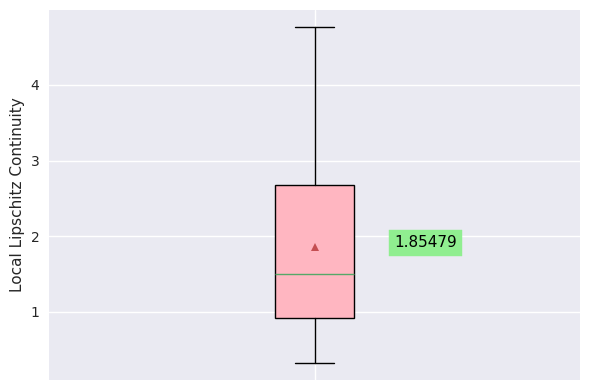

In [33]:
plt.rcParams['figure.figsize'] = [6, 4]
plot_boxplot(data=lip_estimates, mean_values=[np.round(np.mean(lip_estimates), 5)],
             tick_labels=[f''],
             y_label='Local Lipschitz Continuity', colors=['lightpink'], title='')

## Invalidation Rate

In [51]:
classifiers_weights_dir = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/fmnist_classification/binary/checkpoints/mc_0_4'


classifiers_list = []
for clf_weights in os.listdir(classifiers_weights_dir):
    cnn_perturbed = SimpleCNNtorch(**args.classifier_args)
    load_model_weights(model=cnn_perturbed, weights_path=osp.join(classifiers_weights_dir, clf_weights))
    classifiers_list.append(cnn_perturbed)
    evaluate_classification_model(cnn_perturbed, dataloader=test_loader, num_classes=config.data.num_classes)

Accuracy for the test dataset: 98.682%
Accuracy for the test dataset: 97.705%
Accuracy for the test dataset: 97.607%
Accuracy for the test dataset: 97.705%
Accuracy for the test dataset: 97.803%
Accuracy for the test dataset: 96.484%
Accuracy for the test dataset: 97.266%
Accuracy for the test dataset: 97.705%
Accuracy for the test dataset: 98.193%
Accuracy for the test dataset: 97.852%


In [52]:
target_class = 1
validity_list = []
invalidation_rate_list = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for i, classifier in enumerate(classifiers_list):
    validity = 0
    invalidation_rate = 0
    total_found_cfs = 0
    
    classifier.eval()
    with torch.no_grad():
        classifier = classifier.to(device)

        baseline_pred = torch.argmax(baseline_classifier(cfes), axis=1)
        alternative_pred = torch.argmax(classifier(cfes), axis=1)
    
    invalidation_rate = np.where(baseline_pred.detach().cpu() != alternative_pred.detach().cpu())[0].shape[0] / baseline_pred.shape[0]
    validity = np.where(alternative_pred.detach().cpu() == target_class)[0].shape[0] / alternative_pred.shape[0]

    # invalidation_rate /= total_found_cfs
    invalidation_rate_list.append(invalidation_rate)
    validity_list.append(validity)
    print(f'Model {i}: IR={invalidation_rate}, validity={validity}\n')

print('Average IR : {:.3f} +- {:.3f}'.format(np.mean(invalidation_rate_list), np.std(invalidation_rate_list)))
print('Average VaR : {:.3f} +- {:.3f}'.format(np.mean(validity_list), np.std(validity_list)))

Model 0: IR=0.0, validity=1.0

Model 1: IR=0.0, validity=1.0

Model 2: IR=0.0, validity=1.0

Model 3: IR=0.0, validity=1.0

Model 4: IR=0.0, validity=1.0

Model 5: IR=0.0, validity=1.0

Model 6: IR=0.0, validity=1.0

Model 7: IR=0.0, validity=1.0

Model 8: IR=0.0, validity=1.0

Model 9: IR=0.0, validity=1.0

Average IR : 0.000 +- 0.000
Average VaR : 1.000 +- 0.000


## Stability


In [53]:
import torch.nn.functional as F

In [54]:
k = 1000
sigma = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

average_stability_list = []
for i, classifier in enumerate(classifiers_list):
    stability_list = []
    for cfe in cfes:

        cfe = torch.Tensor(cfe).unsqueeze(0).detach().cpu()
        cfe_sampled = torch.Tensor(perturb_sample(cfe, n_samples=k, noise_magnitude=sigma))

        with torch.no_grad():
            cf_logits = classifier(cfe.to(device))
            cf_probabilities = F.softmax(cf_logits, dim=-1)[:, target_class]

            cf_sampled_logits = classifier(cfe_sampled.to(device))
            cf_sampled_probabilities = F.softmax(cf_sampled_logits, dim=-1)[:, target_class]
        
        model_variance = abs(cf_probabilities - cf_sampled_probabilities)

        stability = (cf_sampled_probabilities - model_variance).mean()
        stability_list.append(stability.item())

    avg_i_stability = np.mean(stability_list)
    print(f'Stability of the model {i}: {round(avg_i_stability.item(), 3)} +- {round(np.std(stability_list).item(), 2)}')
    average_stability_list.append(avg_i_stability) 

Stability of the model 0: 1.0 +- 0.0
Stability of the model 1: 1.0 +- 0.0


KeyboardInterrupt: 

In [45]:
print(f'Average stability over {len(classifiers_list)} models:', np.mean(average_stability_list).round(4))

Average stability over 10 models: 0.6866
